# Exercise lecture 8 - Multilayer Perceptron
Develop an MLP for the MNIST
database by using the dimension-reduced data from your work on Exercises 2 and 3. You can download the LDA projected data here.
Further, you can use 10-, 20- and 30-dimensional data generated by PCA and compare
their performance (at the same time, try various MLP architectures).

## Loading data

In [1]:
# Import libraries and create datasets
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from tqdm.autonotebook import tqdm, trange
import time
import os
import warnings
warnings.simplefilter(action='ignore') #Ignore warnings

def create_complete_datasets(data_dict):
    '''
    Function for creating complete training and test sets containing
    all classes.
    '''
    #Empty list
    trainset = []
    traintargets =[]
    testset = []
    testtargets =[]
    
    #For each class
    for i in range(10):
        trainset.append(data_dict["train%d"%i])
        traintargets.append(np.full(len(data_dict["train%d"%i]),i))
        testset.append(data_dict["test%d"%i])
        testtargets.append(np.full(len(data_dict["test%d"%i]),i))
    
    #Concatenate into to complete datasets
    trainset = np.concatenate(trainset)
    traintargets = np.concatenate(traintargets)
    testset = np.concatenate(testset)
    testtargets = np.concatenate(testtargets)
    return trainset, traintargets, testset, testtargets

file = "Data/mnist_all.mat"
data = loadmat(file)

#Complete training and test sets
train_set, train_targets, test_set, test_targets = create_complete_datasets(data)
train_set = train_set/255
test_set = test_set/255
classes = np.arange(10)

#print(f"Classes: \n{classes}")
#print(f"train_targets: \n{train_targets}, shape: {train_targets.shape}")
#print(f"train_set: \n{train_set}, shape: {train_set.shape}")
#print(f"test_targets: \n{test_targets}, shape: {test_targets.shape}")
#print(f"test_set: \n{test_set}, shape: {test_set.shape}")

C:\Users\simon\AppData\Local\Temp\ipykernel_20400\3745780953.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Generating PCA/LDA data
From previous exercises we already know how to use PCA/LDA.
We first fit a PCA/LDA model to our training data, and then transform the training and test data using this model, to get a dimensionality reduced data set.

In [2]:
# Generating PCA/LDA reduced data
# Initialize n_components list
n_components = [10, 20, 30]

# PCA
pca = [PCA(n_components=n_component) for n_component in n_components]
pca_trains = [pca_reduce_train.fit_transform(train_set) for pca_reduce_train in pca ]
pca_tests = [pca_reduce_test.transform(test_set) for pca_reduce_test in pca]
#print("PCA train reduced data:",[pca.shape for pca in pca_trains])
#print("PCA test reduced data:", [pca.shape for pca in pca_tests])

# LDA
lda = LDA(n_components=None)
lda_train = lda.fit_transform(train_set,train_targets)
lda_test = lda.transform(test_set)
#print("LDA train reduced data:",lda_train.shape)
#print("LDA test reduced data:",lda_test.shape)

## Creating and Training MLP
Sklearn has a multilayer perceptron classifier which we can use:
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html 

To use it, we need to choose how many layers we would like to use and the size of each hidden layer. 
We can also choose which non-linear activation function to use and what optimizer/solver to use.
You can set a maximum iteration number as well (to limit compute time).

In [3]:
# Initialize parameter dict
iter = 100
verbose = False
stop = True

# Default activation function and solver
params1 = {
    "max_iter": iter,
    "activation": 'relu',
    "solver": 'adam',
    "verbose": verbose,
    "early_stopping": stop
}

# Using tanh and sgd
params3 = {
    "hidden_layer_sizes": (100,),
    "max_iter": iter,
    "activation": 'tanh',
    "solver": 'sgd',
    "verbose": verbose,
    "early_stopping": stop
}

# Using logistic and sgd
params2 = {
    "hidden_layer_sizes": (100,),
    "max_iter": iter,
    "activation": 'logistic',
    "solver": 'sgd',
    "verbose": verbose,
    "early_stopping": stop
}

# Initialize MLPClassifier object and different architectures
archs = [
    (100,),                 # 1 Hidden layer 100 neurons
    (50, 25),               # 2 Hidden layers 50,25 neurons
    (200, 100, 50, 25),     # 4 Hidden layers 200,100,50,25 neurons
    (300, 300),             # 2 Hidden layers 300,300 neurons
    (64, 128, 64, 32)       # 4 Hidden layers 64,128,64,32 neurons
]
mlp_clfs = [MLPClassifier(hidden_layer_sizes=arch,**params1) for arch in archs]
for mlp_clf in mlp_clfs:
    print(mlp_clf)

MLPClassifier(early_stopping=True, max_iter=100)
MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 25), max_iter=100)
MLPClassifier(early_stopping=True, hidden_layer_sizes=(200, 100, 50, 25),
              max_iter=100)
MLPClassifier(early_stopping=True, hidden_layer_sizes=(300, 300), max_iter=100)
MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 128, 64, 32),
              max_iter=100)


### Model trained on LDA data

In [4]:

# Instantiate MLP with your parameters of choice and train it on the LDA dimensionality reduced training data.
# Afterwards test it on the test data

output_dir =  "Outputs/LDA"
os.makedirs(output_dir,exist_ok=True)

# Train MLPC on LDA reduced data
mlp_ldas = []
timeStart2 = time.time()
cnt = 0
for mlp_clf, arch in tqdm(zip(mlp_clfs, archs), total=len(mlp_clfs), desc="Training..."):
    #print(f"\nClassifier: {mlp_clf}\n {arch}")
    #print(f"--- Training on: 9 Dimensions ---")
    timeStart = time.time()
    mlp_ldas.append(mlp_clf.fit(lda_train, train_targets))
    timeEnd = time.time()
    elapsed_time = timeEnd - timeStart
    
    lda_matrix = confusion_matrix(test_targets,mlp_clf.predict(lda_test))
    lda_cm = ConfusionMatrixDisplay(confusion_matrix=lda_matrix, display_labels=mlp_clf.classes_)
    plt.figure()
    lda_cm.plot()
    plt.title(f"Confusion Matrix of PCA reduced data using MLP\n Architecture: {arch}\n Dimensions: 9")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_{arch}_9.jpg"), format="jpg")
    plt.close()
    
    # Convert elapsed time to minutes or seconds
    if elapsed_time < 60:
        time_unit = "sec"
        time_value = elapsed_time
    else:
        time_unit = "min"
        time_value = elapsed_time / 60
    cnt += 1
    print(f"[INFO] {cnt}/{len(mlp_clfs)} - Training time: {time_value:.2f} {time_unit}")
        
timeEnd2 = time.time()
elapsed_time = timeEnd2 - timeStart2
if elapsed_time < 60:
    time_unit = "seconds"
    time_value = elapsed_time
else:
    time_unit = "minutes"
    time_value = elapsed_time / 60
print(f"Total Training Time: {time_value:.2f} {time_unit}")

print("\n-------------------------\n--- Finished training ---\n-------------------------")

Training...:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] 1/5 - Training time: 3.93 sec
[INFO] 2/5 - Training time: 8.55 sec
[INFO] 3/5 - Training time: 15.28 sec
[INFO] 4/5 - Training time: 23.20 sec
[INFO] 5/5 - Training time: 17.00 sec
Total Training Time: 1.16 minutes

-------------------------
--- Finished training ---
-------------------------


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Model trained on PCA data

In [5]:
# Instantiate MLP with your parameters of choice and train it on the PCA dimensionality reduced training data.
# Afterwards test it on the test data

output_dir =  "Outputs/PCA"
os.makedirs(output_dir,exist_ok=True)

# Train MLPC on PCA reduced data
mlp_pcas = []
timeStart2 = time.time()
cnt = 0
for pca_train, n, pca_test in tqdm(zip(pca_trains, n_components, pca_tests),total=len(pca_trains), desc="Training..."):
    for mlp_clf, arch in tqdm(zip(mlp_clfs, archs),total=len(mlp_clfs), desc="Training...", leave=True, position=cnt):
        #print(f"\nClassifier: {mlp_clf}\n {arch}")
        #print(f"--- Training on: {n} Dimensions ---")
        timeStart = time.time()
        mlp_pcas.append(mlp_clf.fit(pca_train, train_targets))
        timeEnd = time.time()
        elapsed_time = timeEnd - timeStart
        
        pca_matrix = confusion_matrix(test_targets,mlp_clf.predict(pca_test))
        pca_cm = ConfusionMatrixDisplay(confusion_matrix=pca_matrix, display_labels=mlp_clf.classes_)
        plt.figure()
        pca_cm.plot()
        plt.title(f"Confusion Matrix of PCA reduced data using MLP\n Architecture: {arch}\n Dimensions: {n}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"confusion_matrix_{arch}_{n}.jpg"), format="jpg")
        plt.close()
        
        # Convert elapsed time to minutes or seconds
        if elapsed_time < 60:
            time_unit = "seconds"
            time_value = elapsed_time
        else:
            time_unit = "minutes"
            time_value = elapsed_time / 60
        cnt += 1
        print(f"[INFO] {cnt}/{len(mlp_clfs)*3} - Training time: {time_value:.2f} {time_unit}")
timeEnd2 = time.time()
elapsed_time = timeEnd2 - timeStart2
if elapsed_time < 60:
    time_unit = "seconds"
    time_value = elapsed_time
else:
    time_unit = "minutes"
    time_value = elapsed_time / 60
print(f"\nTotal Training Time: {time_value} {time_unit}")

print("\n-------------------------\n--- Finished training ---\n-------------------------")

mlp_pcas = [[mlp_pcas[0], mlp_pcas[3], mlp_pcas[6],mlp_pcas[9], mlp_pcas[12]],
             [mlp_pcas[1], mlp_pcas[4], mlp_pcas[7], mlp_pcas[10], mlp_pcas[13]],
             [mlp_pcas[2], mlp_pcas[5], mlp_pcas[8], mlp_pcas[11], mlp_pcas[14]]]


Training...:   0%|          | 0/3 [00:00<?, ?it/s]

Training...:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] 1/15 - Training time: 12.49 seconds
[INFO] 2/15 - Training time: 8.95 seconds
[INFO] 3/15 - Training time: 19.56 seconds
[INFO] 4/15 - Training time: 33.10 seconds
[INFO] 5/15 - Training time: 29.26 seconds


Training...:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] 6/15 - Training time: 11.74 seconds
[INFO] 7/15 - Training time: 7.95 seconds
[INFO] 8/15 - Training time: 23.68 seconds
[INFO] 9/15 - Training time: 1.09 minutes
[INFO] 10/15 - Training time: 17.91 seconds


Training...:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] 11/15 - Training time: 15.13 seconds
[INFO] 12/15 - Training time: 10.82 seconds
[INFO] 13/15 - Training time: 20.84 seconds
[INFO] 14/15 - Training time: 47.11 seconds
[INFO] 15/15 - Training time: 14.21 seconds

Total Training Time: 5.705971686045329 minutes

-------------------------
--- Finished training ---
-------------------------


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

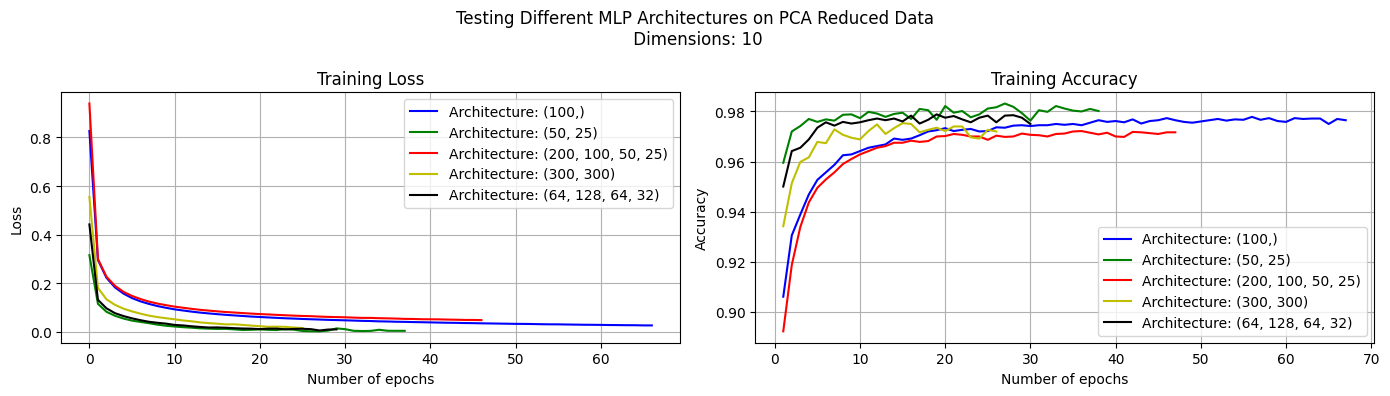

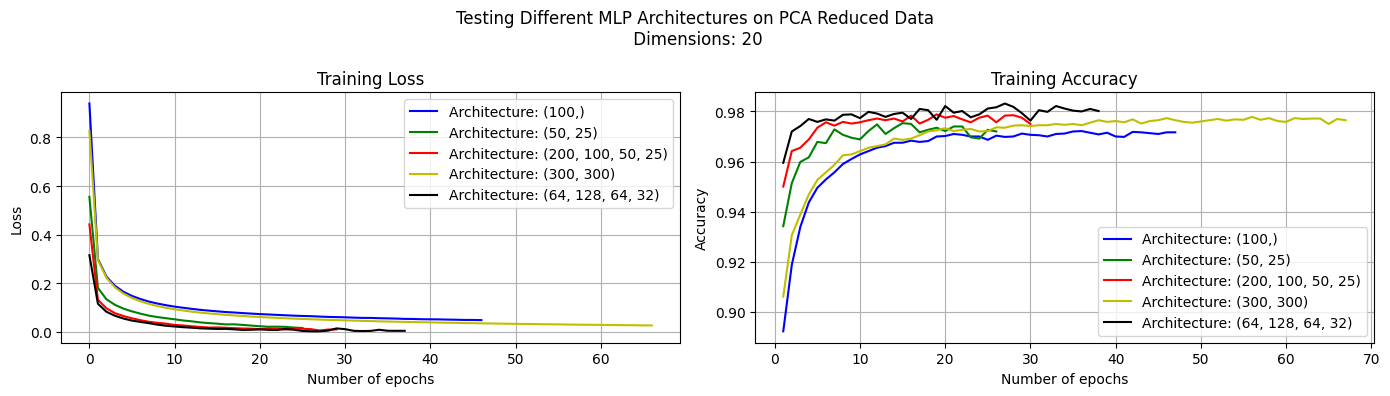

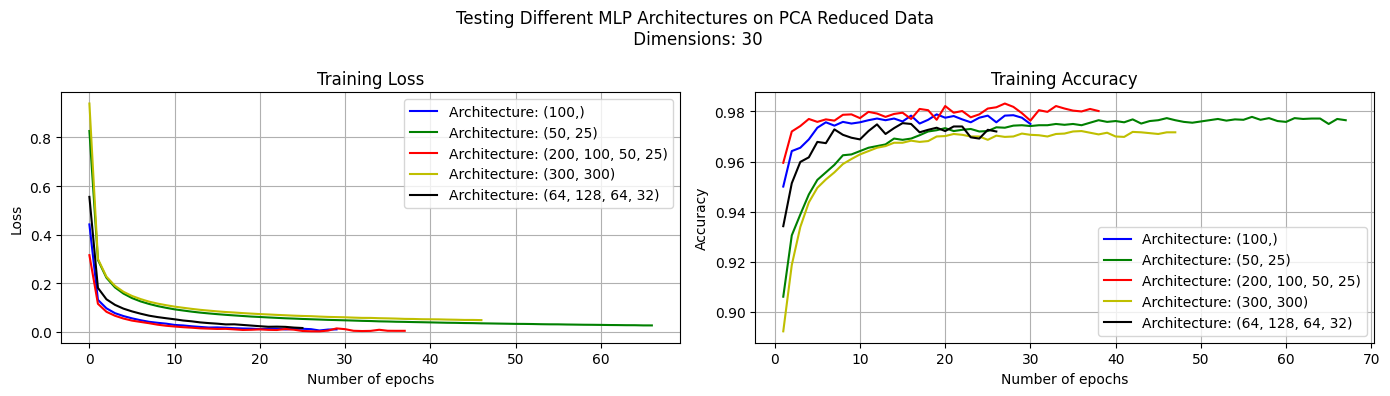

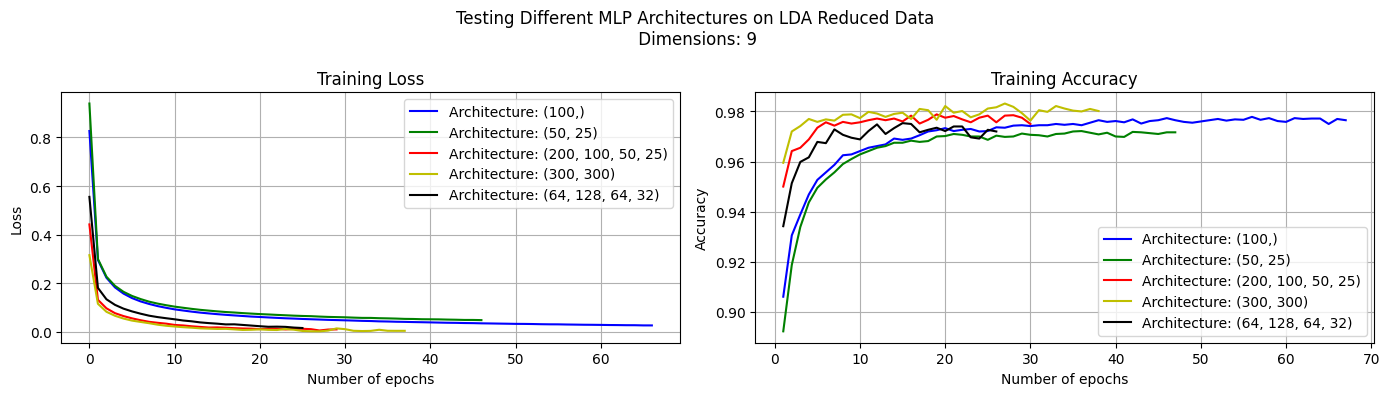

In [6]:
# Plot loss/accuracy during training PCA
for mlp_pca, n in zip(mlp_pcas, n_components):
    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Testing Different MLP Architectures on PCA Reduced Data\n Dimensions: {n}")

    for i, arch in enumerate(archs):
        mlp_pca_acc = mlp_pca[i].validation_scores_
        plt.subplot(1, 2, 1)
        plt.title(f"Training Loss")
        plt.plot(mlp_pca[i].loss_curve_, label=f"Architecture: {arch}", color=["b", "g", "r", "y", "k"][i])

        plt.subplot(1, 2, 2)
        plt.title(f"Training Accuracy")
        plt.plot(range(1, len(mlp_pca_acc) + 1), mlp_pca_acc, label=f"Architecture: {arch}", color=["b", "g", "r", "y", "k"][i])

    plt.subplot(1, 2, 1)
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.tight_layout()


# Plot loss/accuracy during training LDA
plt.figure(figsize=(14, 4))
plt.suptitle(f"Testing Different MLP Architectures on LDA Reduced Data\n Dimensions: 9")
for i in range(len(mlp_ldas)):
    mlp_lda_acc = mlp_ldas[i].validation_scores_
    plt.subplot(1, 2, 1)
    plt.title(f"Training Loss")
    plt.plot(mlp_ldas[i].loss_curve_, label=f"Architecture: {archs[i]}", color=["b", "g", "r", "y", "k"][i])
    
    plt.subplot(1, 2, 2)
    plt.title(f"Training Accuracy")
    plt.plot(range(1, len(mlp_lda_acc) + 1), mlp_lda_acc, label=f"Architecture: {archs[i]}", color=["b", "g", "r", "y", "k"][i])

plt.subplot(1, 2, 1)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()

## Comparing the trained models
With models trained on both LDA and PCA data, let's compare them using the confusion matrices.

What can we conclude from the comparison?